In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import scipy.io
import tensorflow as tf
import tensorflow_addons as tfa
import pandas as pd
import os

from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Conv2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

c:\Users\ryang\miniconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
label=pd.read_csv('Forest Segmented\meta_data.csv')

classes = {
    '0': (0, 0, 0,),
    '1': (255, 255, 255)
}

print(label)

path_original_images = 'Forest Segmented/images'
path_label_images = 'Forest Segmented/masks'
num_class = 1

print(num_class)

                  image                mask
0      10452_sat_08.jpg   10452_mask_08.jpg
1      10452_sat_18.jpg   10452_mask_18.jpg
2     111335_sat_00.jpg  111335_mask_00.jpg
3     111335_sat_01.jpg  111335_mask_01.jpg
4     111335_sat_02.jpg  111335_mask_02.jpg
...                 ...                 ...
5103  998002_sat_31.jpg  998002_mask_31.jpg
5104  998002_sat_32.jpg  998002_mask_32.jpg
5105  998002_sat_40.jpg  998002_mask_40.jpg
5106  998002_sat_41.jpg  998002_mask_41.jpg
5107  998002_sat_50.jpg  998002_mask_50.jpg

[5108 rows x 2 columns]
1


In [4]:
img, msk = label.items()

In [5]:
def normalize(n):
    return n/255.0

In [6]:
def get_original_images():
    temp_img = []
    for a in range(img[1].shape[0]):
        temp_img.append(tf.keras.preprocessing.image.img_to_array(tf.keras.utils.load_img(f"{path_original_images}/{img[1][a]}", target_size=(128,128))))
    
    return np.array(temp_img)

In [7]:
def classconvert():
    rtn = []
    for a in range(msk[1].shape[0]):
        img_mask = tf.keras.preprocessing.image.img_to_array(tf.keras.utils.load_img(f"{path_label_images}/{msk[1][a]}", target_size=(128,128)))
        temp_mask = np.zeros(shape=(img_mask.shape[0], img_mask.shape[1]), dtype = np.uint32)

        for row in range(img_mask.shape[0]):
            for col in range(img_mask.shape[1]):
                if img_mask[row, col, 0] > 128:
                    temp_mask[row, col] = 1
        temp_mask = np.reshape(temp_mask, (temp_mask.shape[0], temp_mask.shape[1], 1))
        rtn.append(temp_mask)
    return np.array(rtn)

In [8]:
def output_to_image(out_img):
    img = np.zeros(shape=(out_img.shape[0], out_img.shape[1], 1), dtype = np.uint32)
    for row in range(out_img.shape[0]):
        for col in range(out_img.shape[1]):
            img[row,col,:] = np.array(0 if out_img[row,col] < 0.5 else 1)
    return img

In [9]:
def mask_to_image(mask):
    img = np.zeros(shape=(mask.shape[0], mask.shape[1], 3), dtype = np.uint32)
    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            img[row,col,:] = np.array(classes[str(mask[row,col][0])])
    return img

In [10]:
import random

def generate_dataset(dataset, noiseset, noiselevel = 0.2):
    temp = []
    random_indexes = random.sample(range(len(dataset)), int(len(dataset) * noiselevel))
    for i in range(len(dataset)):
        if i in random_indexes:
            temp.append(noiseset[i])
        else:
            temp.append(dataset[i])
    return np.array(temp)

In [11]:
x = normalize(np.load('x.npy'))
y = np.load('y.npy')

x_train = x[0:4086]
y_train = y[0:4086]
x_val = x[4086:5180]
y_val = y[4086:5180]

edge = normalize(np.load("edge.npy"))
hist = normalize(np.load("hist.npy"))
edge_hist = normalize(np.load("edge_hist.npy"))

dataset_edge = edge[0:4086]
dataset_hist = hist[0:4086]
dataset_edge_hist = edge_hist[0:4086]

dataset_edge_val = edge[4086:5180]
dataset_hist_val = hist[4086:5180]
dataset_edge_hist_val = edge_hist[4086:5180]

dataset_noise = normalize(np.load("dataset_noise.npy"))
dataset_edge_noise = normalize(np.load("dataset_edge_noise.npy"))
dataset_hist_noise = normalize(np.load("dataset_hist_noise.npy"))
dataset_all = normalize(np.load("dataset_all.npy"))

dataset_noise_val = x[4086:5180]
dataset_edge_noise_val = edge[4086:5180]
dataset_hist_noise_val = hist[4086:5180]
dataset_all_val = edge_hist[4086:5180]

In [13]:
def conv(input, n):
  x = keras.layers.Conv2D(n, 3, padding='same', activation='relu')(input)
  x = keras.layers.BatchNormalization()(x)

  x = keras.layers.Conv2D(n, 3, padding='same', activation='relu')(x)

  return x

In [14]:
def encoder(input, n, drop):
  x = conv(input, n)
  if drop > 0.0:
    c = keras.layers.Dropout(0.2)(x)
    c = keras.layers.MaxPooling2D(pool_size=(2,2))(c)
  else:
    c = keras.layers.MaxPooling2D(pool_size=(2,2))(x)
  return x, c

In [15]:
def decoder(input, concat, n):
  x = keras.layers.Conv2DTranspose(n, (2,2), strides=2, padding='same')(input)
  x = keras.layers.Concatenate()([x, concat])
  x = conv(x, n)
  return x

In [16]:
def build_unet(input_shape, drop):
    inputs = keras.layers.Input(input_shape)

    s1, p1 = encoder(inputs, 16, drop)
    s2, p2 = encoder(p1, 32, drop)
    s3, p3 = encoder(p2, 64, drop)
    s4, p4 = encoder(p3, 128, drop)
    s5, p5 = encoder(p4, 256, drop)
    s6, p6 = encoder(p5, 512, drop)

    b1 = conv(p6, 1024)

    d1 = decoder(b1, s6, 512)
    d2 = decoder(d1, s5, 256)
    d3 = decoder(d2, s4, 128)
    d4 = decoder(d3, s3, 64)
    d5 = decoder(d4, s2, 32)
    d6 = decoder(d5, s1, 16)

    outputs = Conv2D(num_class, kernel_size=(3,3), strides=1, padding="same", activation="sigmoid")(d6)

    model = keras.Model(inputs=[inputs], outputs=[outputs], name="U-Net")
    return model

In [17]:
input_shape = (128,128,3)
model_unet7 = build_unet(input_shape, 0.5)
model_unet7.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [18]:
def shuffle(arr1, arr2):
    randomize = np.arange(len(arr1))
    np.random.shuffle(randomize)
    return arr1[randomize], arr2[randomize]

In [19]:
# Function to calculate Intersection over Union (IoU)
def calculate_iou(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

# Function to calculate Mean Intersection over Union (mIoU)
def calculate_miou(y_true, y_pred, smooth=1):
    iou_foreground = calculate_iou(y_true, y_pred, smooth)
    iou_background = calculate_iou(1 - y_true, 1 - y_pred, smooth)
    miou = (iou_foreground + iou_background) / 2
    return miou

# Function to calculate Dice Coefficient
def calculate_dice(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return dice

# Custom metric for mIoU
def mean_iou(y_true, y_pred):
    return calculate_miou(y_true, tf.round(y_pred))

# Custom metric for Dice Coefficient
def dice_coef(y_true, y_pred):
    return calculate_dice(y_true, tf.round(y_pred))

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10, restore_best_weights = True)

In [21]:
batch_s = 32
epoch = 50

In [22]:
loss = tf.keras.losses.BinaryCrossentropy()

In [23]:
iteration = 10

In [24]:
print("unet7_saved_models/" + f"{iteration}" + "/unet7_100_epoch_force.h5")

unet7_saved_models/10/unet7_100_epoch_force.h5


In [25]:
model_unet7.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy", mean_iou, dice_coef])

check_path = './checkpoint/' + f'{iteration}' + '/model_unet7/model_unet7_{epoch:04d}_{val_loss:.4f}_{val_accuracy:.4f}_{val_mean_iou:.4f}_{val_dice_coef:.4f}_.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=check_path, monitor='val_dice_coef', mode='max', save_best_only=True, save_weights_only=True)

x_shuffle, y_shuffle = shuffle(x_train, y_train)

results = model_unet7.fit(x=x_shuffle, y=y_shuffle, batch_size=batch_s, epochs=epoch, validation_data=(x_val,y_val), callbacks=[checkpoint])
model_unet7.save("unet7_saved_models/" + f"{iteration}" + "/unet7_100_epoch_force.h5")
np.save("history/" + f"{iteration}" + "/unet7_history.npy", results.history)

Epoch 1/50
128/128 [==============================] - 16s 57ms/step - loss: 0.4995 - accuracy: 0.7695 - mean_iou: 0.6093 - dice_coef: 0.8151 - val_loss: 1.1919 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.9557e-06
Epoch 2/50
128/128 [==============================] - 5s 41ms/step - loss: 0.4516 - accuracy: 0.7972 - mean_iou: 0.6469 - dice_coef: 0.8382 - val_loss: 1.8984 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.1381e-06
Epoch 3/50
128/128 [==============================] - 5s 42ms/step - loss: 0.4414 - accuracy: 0.8015 - mean_iou: 0.6518 - dice_coef: 0.8421 - val_loss: 1.0996 - val_accuracy: 0.4724 - val_mean_iou: 0.2848 - val_dice_coef: 0.2639
Epoch 4/50
128/128 [==============================] - 5s 42ms/step - loss: 0.4313 - accuracy: 0.8070 - mean_iou: 0.6594 - dice_coef: 0.8469 - val_loss: 0.7695 - val_accuracy: 0.6548 - val_mean_iou: 0.4854 - val_dice_coef: 0.6393
Epoch 5/50
128/128 [==============================] - 5s 41ms/step - loss: 

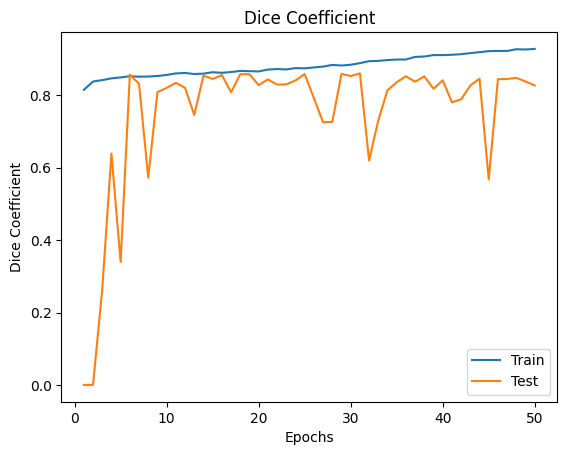

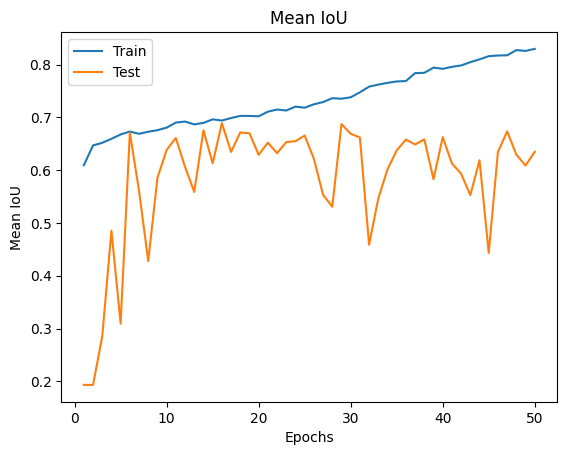

In [26]:
dice = results.history['dice_coef']
val_dice = results.history['val_dice_coef']
epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, label='Train')
plt.plot(epochs, val_dice, label='Test')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

iou = results.history['mean_iou']
val_iou = results.history['val_mean_iou']

plt.plot(epochs, iou, label='Train')
plt.plot(epochs, val_iou, label='Test')
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()

In [27]:
input_shape = (128,128,3)
model_unet = build_unet(input_shape, 0.5)

model_unet.compile(loss = loss, optimizer = "adam", metrics = ["accuracy", mean_iou, dice_coef])

check_path = './checkpoint/' + f'{iteration}' + '/model_unet7_noise/model_unet_{epoch:04d}_{val_loss:.4f}_{val_accuracy:.4f}_{val_mean_iou:.4f}_{val_dice_coef:.4f}_.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=check_path, monitor='val_dice_coef', mode='max', save_best_only=True, save_weights_only=True)

x_shuffle, y_shuffle = shuffle(dataset_noise, y_train)

results_unet_n = model_unet.fit(x=x_shuffle, y=y_shuffle, batch_size=batch_s, epochs=epoch, validation_data=(dataset_noise_val,y_val), callbacks=[checkpoint])
model_unet.save("unet7_saved_models/" + f"{iteration}" + "/noise_100_epoch_force.h5")
np.save("history/" + f"{iteration}" + "/unet7_history_n.npy", results_unet_n.history)

Epoch 1/50
128/128 [==============================] - 8s 48ms/step - loss: 0.5147 - accuracy: 0.7603 - mean_iou: 0.5959 - dice_coef: 0.8042 - val_loss: 6.5243 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.1381e-06
Epoch 2/50
128/128 [==============================] - 5s 41ms/step - loss: 0.4664 - accuracy: 0.7896 - mean_iou: 0.6349 - dice_coef: 0.8329 - val_loss: 2.6813 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 3.1381e-06
Epoch 3/50
128/128 [==============================] - 5s 42ms/step - loss: 0.4468 - accuracy: 0.8009 - mean_iou: 0.6514 - dice_coef: 0.8414 - val_loss: 3.0980 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 4.5291e-06
Epoch 4/50
128/128 [==============================] - 6s 45ms/step - loss: 0.4345 - accuracy: 0.8068 - mean_iou: 0.6600 - dice_coef: 0.8458 - val_loss: 1.8344 - val_accuracy: 0.4282 - val_mean_iou: 0.2376 - val_dice_coef: 0.1370
Epoch 5/50
128/128 [==============================] - 5s 43ms/step - los

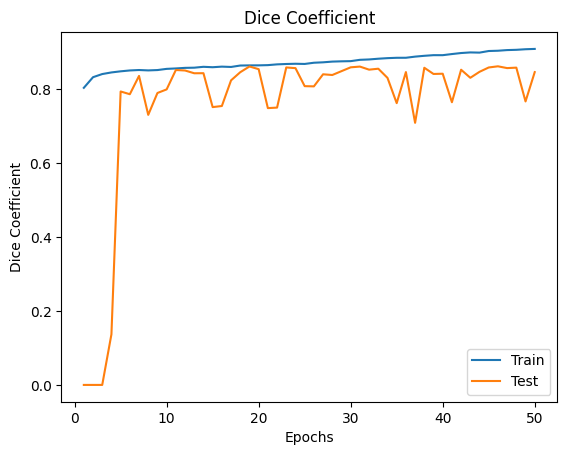

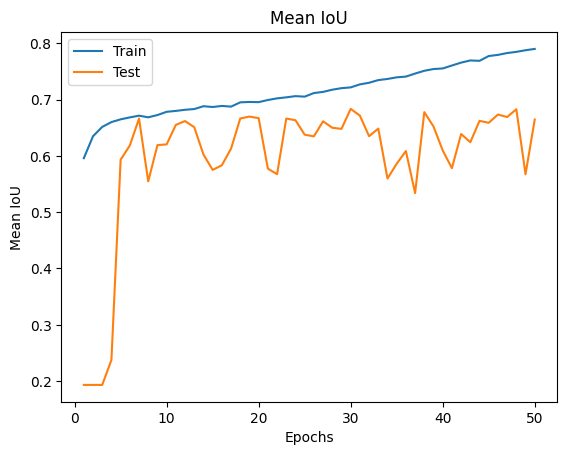

In [28]:
dice = results_unet_n.history['dice_coef']
val_dice = results_unet_n.history['val_dice_coef']
epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, label='Train')
plt.plot(epochs, val_dice, label='Test')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

iou = results_unet_n.history['mean_iou']
val_iou = results_unet_n.history['val_mean_iou']

plt.plot(epochs, iou, label='Train')
plt.plot(epochs, val_iou, label='Test')
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()

In [29]:
input_shape = (128,128,3)
model_unet = build_unet(input_shape, 0.5)

model_unet.compile(loss = loss, optimizer = "adam", metrics = ["accuracy", mean_iou, dice_coef])

check_path = './checkpoint/' + f'{iteration}' + '/model_unet7_edge/model_unet_{epoch:04d}_{val_loss:.4f}_{val_accuracy:.4f}_{val_mean_iou:.4f}_{val_dice_coef:.4f}_.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=check_path, monitor='val_dice_coef', mode='max', save_best_only=True, save_weights_only=True)

x_shuffle, y_shuffle = shuffle(dataset_edge, y_train)

results_unet_e = model_unet.fit(x=x_shuffle, y=y_shuffle, batch_size=batch_s, epochs=epoch, validation_data=(dataset_edge_val,y_val), callbacks=[checkpoint])
model_unet.save("unet7_saved_models/" + f"{iteration}" + "/edge_100_epoch_force.h5")
np.save("history/" + f"{iteration}" + "/unet7_history_e.npy", results_unet_e.history)

Epoch 1/50
128/128 [==============================] - 8s 48ms/step - loss: 0.5136 - accuracy: 0.7631 - mean_iou: 0.5986 - dice_coef: 0.8118 - val_loss: 4.0137 - val_accuracy: 0.3863 - val_mean_iou: 0.1933 - val_dice_coef: 2.7120e-04
Epoch 2/50
128/128 [==============================] - 5s 41ms/step - loss: 0.4723 - accuracy: 0.7883 - mean_iou: 0.6328 - dice_coef: 0.8324 - val_loss: 2.8059 - val_accuracy: 0.3863 - val_mean_iou: 0.1933 - val_dice_coef: 1.2377e-04
Epoch 3/50
128/128 [==============================] - 5s 42ms/step - loss: 0.4508 - accuracy: 0.7994 - mean_iou: 0.6489 - dice_coef: 0.8405 - val_loss: 1.9122 - val_accuracy: 0.3934 - val_mean_iou: 0.2007 - val_dice_coef: 0.0235
Epoch 4/50
128/128 [==============================] - 5s 42ms/step - loss: 0.4411 - accuracy: 0.8036 - mean_iou: 0.6541 - dice_coef: 0.8441 - val_loss: 0.4778 - val_accuracy: 0.7788 - val_mean_iou: 0.5980 - val_dice_coef: 0.8389
Epoch 5/50
128/128 [==============================] - 5s 42ms/step - loss: 0

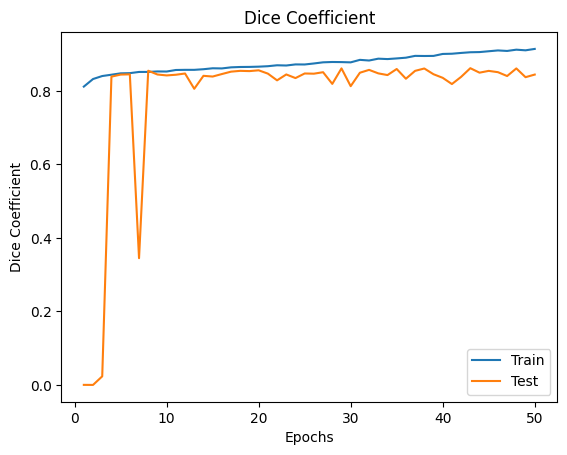

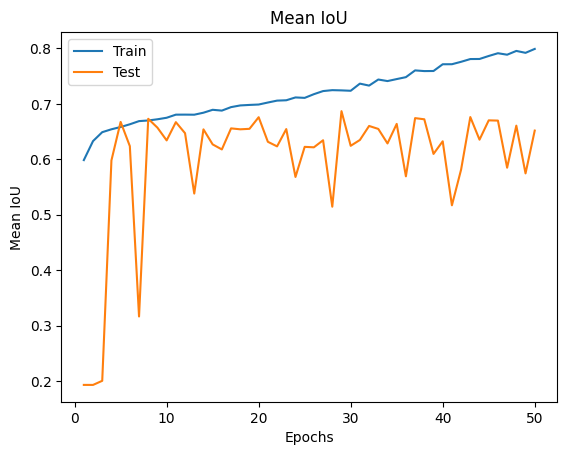

In [30]:
dice = results_unet_e.history['dice_coef']
val_dice = results_unet_e.history['val_dice_coef']
epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, label='Train')
plt.plot(epochs, val_dice, label='Test')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

iou = results_unet_e.history['mean_iou']
val_iou = results_unet_e.history['val_mean_iou']

plt.plot(epochs, iou, label='Train')
plt.plot(epochs, val_iou, label='Test')
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()

In [31]:
input_shape = (128,128,3)
model_unet = build_unet(input_shape, 0.5)

model_unet.compile(loss = loss, optimizer = "adam", metrics = ["accuracy", mean_iou, dice_coef])

check_path = './checkpoint/' + f'{iteration}' + '/model_unet7_hist/model_unet_{epoch:04d}_{val_loss:.4f}_{val_accuracy:.4f}_{val_mean_iou:.4f}_{val_dice_coef:.4f}_.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=check_path, monitor='val_dice_coef', mode='max', save_best_only=True, save_weights_only=True)

x_shuffle, y_shuffle = shuffle(dataset_hist, y_train)

results_unet_h = model_unet.fit(x=x_shuffle, y=y_shuffle, batch_size=batch_s, epochs=epoch, validation_data=(dataset_hist_val,y_val), callbacks=[checkpoint])
model_unet.save("unet7_saved_models/" + f"{iteration}" + "/hist_100_epoch_force.h5")
np.save("history/" + f"{iteration}" + "/unet7_history_h.npy", results_unet_h.history)

Epoch 1/50
128/128 [==============================] - 8s 49ms/step - loss: 0.5261 - accuracy: 0.7507 - mean_iou: 0.5832 - dice_coef: 0.8015 - val_loss: 0.8819 - val_accuracy: 0.3868 - val_mean_iou: 0.1940 - val_dice_coef: 0.0034
Epoch 2/50
128/128 [==============================] - 5s 41ms/step - loss: 0.4751 - accuracy: 0.7860 - mean_iou: 0.6294 - dice_coef: 0.8303 - val_loss: 0.9347 - val_accuracy: 0.3866 - val_mean_iou: 0.1937 - val_dice_coef: 0.0020
Epoch 3/50
128/128 [==============================] - 5s 42ms/step - loss: 0.4610 - accuracy: 0.7923 - mean_iou: 0.6401 - dice_coef: 0.8345 - val_loss: 1.8761 - val_accuracy: 0.3924 - val_mean_iou: 0.1997 - val_dice_coef: 0.0207
Epoch 4/50
128/128 [==============================] - 5s 42ms/step - loss: 0.4534 - accuracy: 0.7964 - mean_iou: 0.6442 - dice_coef: 0.8385 - val_loss: 0.5484 - val_accuracy: 0.7027 - val_mean_iou: 0.5399 - val_dice_coef: 0.7121
Epoch 5/50
128/128 [==============================] - 5s 42ms/step - loss: 0.4447 - 

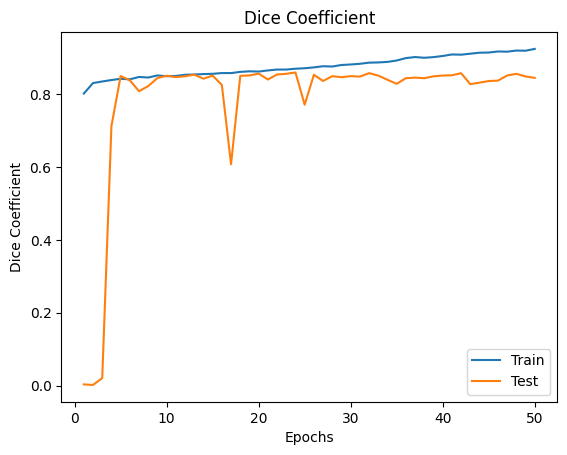

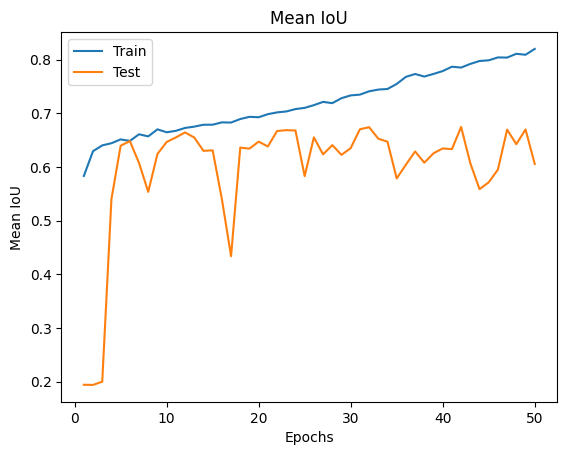

In [32]:
dice = results_unet_h.history['dice_coef']
val_dice = results_unet_h.history['val_dice_coef']
epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, label='Train')
plt.plot(epochs, val_dice, label='Test')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

iou = results_unet_h.history['mean_iou']
val_iou = results_unet_h.history['val_mean_iou']

plt.plot(epochs, iou, label='Train')
plt.plot(epochs, val_iou, label='Test')
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()

In [33]:
input_shape = (128,128,3)
model_unet = build_unet(input_shape, 0.5)

model_unet.compile(loss = loss, optimizer = "adam", metrics = ["accuracy", mean_iou, dice_coef])

check_path = './checkpoint/' + f'{iteration}' + '/model_unet7_noise_edge/model_unet_{epoch:04d}_{val_loss:.4f}_{val_accuracy:.4f}_{val_mean_iou:.4f}_{val_dice_coef:.4f}_.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=check_path, monitor='val_dice_coef', mode='max', save_best_only=True, save_weights_only=True)

x_shuffle, y_shuffle = shuffle(dataset_edge_noise, y_train)

results_unet_ne = model_unet.fit(x=x_shuffle, y=y_shuffle, batch_size=batch_s, epochs=epoch, validation_data=(dataset_edge_noise_val,y_val), callbacks=[checkpoint])
model_unet.save("unet7_saved_models/" + f"{iteration}" + "/noise_edge_100_epoch_force.h5")
np.save("history/" + f"{iteration}" + "/unet7_history_ne.npy", results_unet_ne.history)

Epoch 1/50
128/128 [==============================] - 8s 48ms/step - loss: 0.5135 - accuracy: 0.7596 - mean_iou: 0.5952 - dice_coef: 0.8083 - val_loss: 2.2554 - val_accuracy: 0.3863 - val_mean_iou: 0.1932 - val_dice_coef: 4.9642e-05
Epoch 2/50
128/128 [==============================] - 5s 41ms/step - loss: 0.4570 - accuracy: 0.7929 - mean_iou: 0.6391 - dice_coef: 0.8363 - val_loss: 1.6898 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 7.5314e-06
Epoch 3/50
128/128 [==============================] - 5s 42ms/step - loss: 0.4498 - accuracy: 0.7969 - mean_iou: 0.6456 - dice_coef: 0.8388 - val_loss: 1.5565 - val_accuracy: 0.3896 - val_mean_iou: 0.1968 - val_dice_coef: 0.0116
Epoch 4/50
128/128 [==============================] - 5s 42ms/step - loss: 0.4390 - accuracy: 0.8030 - mean_iou: 0.6546 - dice_coef: 0.8429 - val_loss: 0.6761 - val_accuracy: 0.7180 - val_mean_iou: 0.5598 - val_dice_coef: 0.7330
Epoch 5/50
128/128 [==============================] - 5s 42ms/step - loss: 0

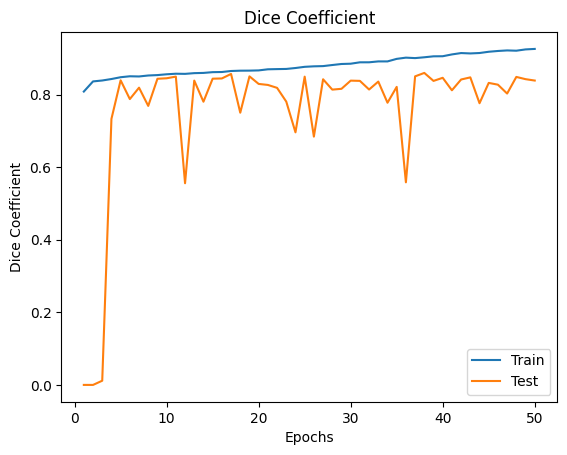

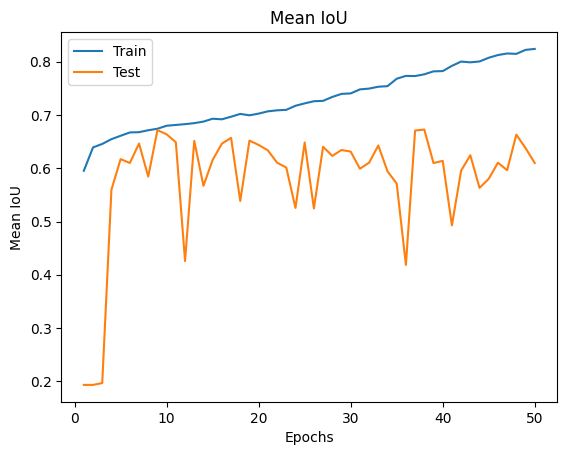

In [34]:
dice = results_unet_ne.history['dice_coef']
val_dice = results_unet_ne.history['val_dice_coef']
epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, label='Train')
plt.plot(epochs, val_dice, label='Test')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

iou = results_unet_ne.history['mean_iou']
val_iou = results_unet_ne.history['val_mean_iou']

plt.plot(epochs, iou, label='Train')
plt.plot(epochs, val_iou, label='Test')
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()

In [35]:
input_shape = (128,128,3)
model_unet = build_unet(input_shape, 0.5)

model_unet.compile(loss = loss, optimizer = "adam", metrics = ["accuracy", mean_iou, dice_coef])

check_path = './checkpoint/' + f'{iteration}' + '/model_unet7_noise_hist/model_unet_{epoch:04d}_{val_loss:.4f}_{val_accuracy:.4f}_{val_mean_iou:.4f}_{val_dice_coef:.4f}_.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=check_path, monitor='val_dice_coef', mode='max', save_best_only=True, save_weights_only=True)

x_shuffle, y_shuffle = shuffle(dataset_hist_noise, y_train)

results_unet_nh = model_unet.fit(x=x_shuffle, y=y_shuffle, batch_size=batch_s, epochs=epoch, validation_data=(dataset_hist_noise_val,y_val), callbacks=[checkpoint])
model_unet.save("unet7_saved_models/" + f"{iteration}" + "/noise_hist_100_epoch_force.h5")
np.save("history/" + f"{iteration}" + "/unet7_history_nh.npy", results_unet_nh.history)

Epoch 1/50
128/128 [==============================] - 7s 45ms/step - loss: 0.5337 - accuracy: 0.7430 - mean_iou: 0.5706 - dice_coef: 0.7983 - val_loss: 6.8840 - val_accuracy: 0.4533 - val_mean_iou: 0.2903 - val_dice_coef: 0.3992
Epoch 2/50
128/128 [==============================] - 5s 41ms/step - loss: 0.4800 - accuracy: 0.7810 - mean_iou: 0.6218 - dice_coef: 0.8272 - val_loss: 5.4237 - val_accuracy: 0.3863 - val_mean_iou: 0.1933 - val_dice_coef: 1.2304e-04
Epoch 3/50
128/128 [==============================] - 5s 41ms/step - loss: 0.4579 - accuracy: 0.7939 - mean_iou: 0.6409 - dice_coef: 0.8362 - val_loss: 2.1537 - val_accuracy: 0.3863 - val_mean_iou: 0.1933 - val_dice_coef: 1.4976e-04
Epoch 4/50
128/128 [==============================] - 5s 41ms/step - loss: 0.4506 - accuracy: 0.7976 - mean_iou: 0.6461 - dice_coef: 0.8395 - val_loss: 2.2313 - val_accuracy: 0.4208 - val_mean_iou: 0.2313 - val_dice_coef: 0.1183
Epoch 5/50
128/128 [==============================] - 5s 42ms/step - loss: 0

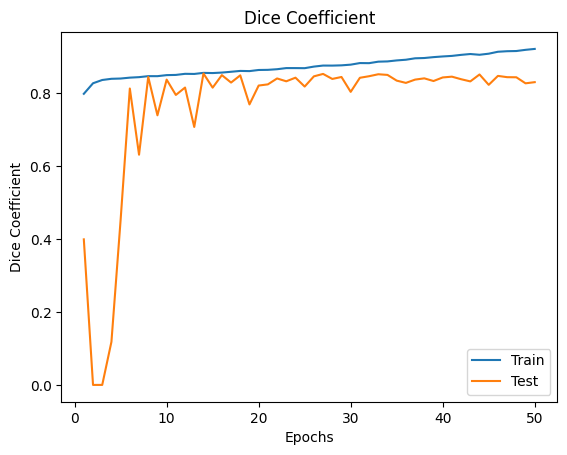

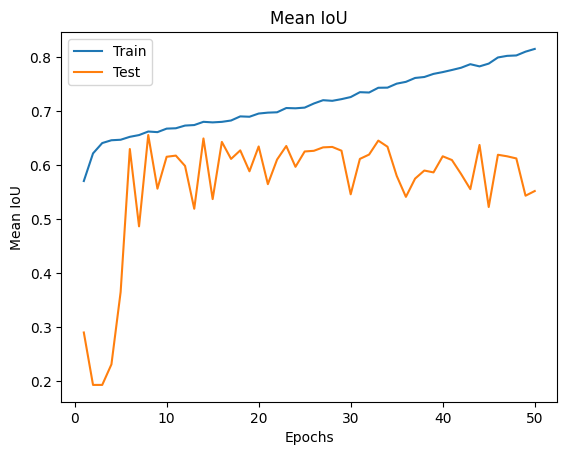

In [36]:
dice = results_unet_nh.history['dice_coef']
val_dice = results_unet_nh.history['val_dice_coef']
epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, label='Train')
plt.plot(epochs, val_dice, label='Test')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

iou = results_unet_nh.history['mean_iou']
val_iou = results_unet_nh.history['val_mean_iou']

plt.plot(epochs, iou, label='Train')
plt.plot(epochs, val_iou, label='Test')
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()

In [37]:
input_shape = (128,128,3)
model_unet = build_unet(input_shape, 0.5)

model_unet.compile(loss = loss, optimizer = "adam", metrics = ["accuracy", mean_iou, dice_coef])

check_path = './checkpoint/' + f'{iteration}' + '/model_unet7_edge_hist/model_unet_{epoch:04d}_{val_loss:.4f}_{val_accuracy:.4f}_{val_mean_iou:.4f}_{val_dice_coef:.4f}_.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=check_path, monitor='val_dice_coef', mode='max', save_best_only=True, save_weights_only=True)

x_shuffle, y_shuffle = shuffle(dataset_edge_hist, y_train)

results_unet_eh = model_unet.fit(x=x_shuffle, y=y_shuffle, batch_size=batch_s, epochs=epoch, validation_data=(dataset_edge_hist_val,y_val), callbacks=[checkpoint])
model_unet.save("unet7_saved_models/" + f"{iteration}" + "/edge_hist_100_epoch_force.h5")
np.save("history/" + f"{iteration}" + "/unet7_history_eh.npy", results_unet_eh.history)

Epoch 1/50
128/128 [==============================] - 8s 49ms/step - loss: 0.5374 - accuracy: 0.7393 - mean_iou: 0.5690 - dice_coef: 0.7911 - val_loss: 1.4191 - val_accuracy: 0.3872 - val_mean_iou: 0.1949 - val_dice_coef: 0.0075
Epoch 2/50
128/128 [==============================] - 5s 40ms/step - loss: 0.4889 - accuracy: 0.7762 - mean_iou: 0.6156 - dice_coef: 0.8240 - val_loss: 3.8512 - val_accuracy: 0.3862 - val_mean_iou: 0.1932 - val_dice_coef: 1.0103e-05
Epoch 3/50
128/128 [==============================] - 5s 41ms/step - loss: 0.4637 - accuracy: 0.7910 - mean_iou: 0.6372 - dice_coef: 0.8339 - val_loss: 3.0086 - val_accuracy: 0.3905 - val_mean_iou: 0.1975 - val_dice_coef: 0.0140
Epoch 4/50
128/128 [==============================] - 5s 41ms/step - loss: 0.4475 - accuracy: 0.7997 - mean_iou: 0.6486 - dice_coef: 0.8414 - val_loss: 0.7581 - val_accuracy: 0.5657 - val_mean_iou: 0.3872 - val_dice_coef: 0.4836
Epoch 5/50
128/128 [==============================] - 5s 41ms/step - loss: 0.439

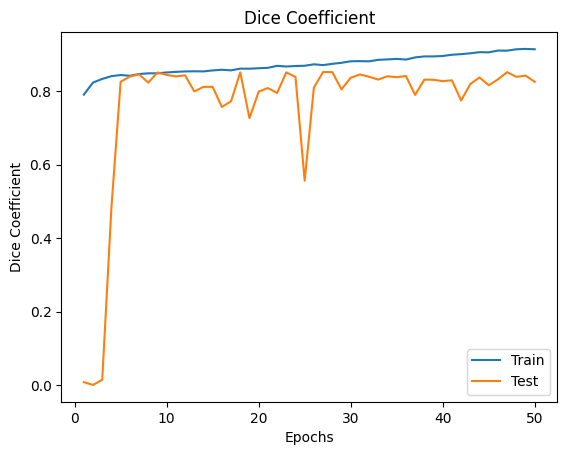

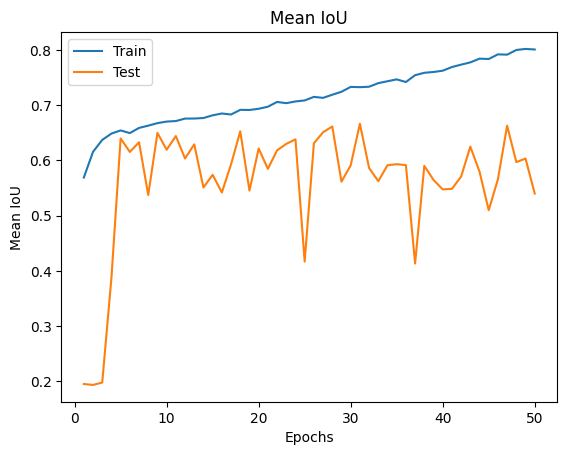

In [38]:
dice = results_unet_eh.history['dice_coef']
val_dice = results_unet_eh.history['val_dice_coef']
epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, label='Train')
plt.plot(epochs, val_dice, label='Test')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

iou = results_unet_eh.history['mean_iou']
val_iou = results_unet_eh.history['val_mean_iou']

plt.plot(epochs, iou, label='Train')
plt.plot(epochs, val_iou, label='Test')
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()

In [39]:
input_shape = (128,128,3)
model_unet = build_unet(input_shape, 0.5)

model_unet.compile(loss = loss, optimizer = "adam", metrics = ["accuracy", mean_iou, dice_coef])

check_path = './checkpoint/' + f'{iteration}' + '/model_unet7_all/model_unet_{epoch:04d}_{val_loss:.4f}_{val_accuracy:.4f}_{val_mean_iou:.4f}_{val_dice_coef:.4f}_.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=check_path, monitor='val_dice_coef', mode='max', save_best_only=True, save_weights_only=True)

x_shuffle, y_shuffle = shuffle(dataset_all, y_train)

results_unet_all = model_unet.fit(x=x_shuffle, y=y_shuffle, batch_size=batch_s, epochs=epoch, validation_data=(dataset_all_val,y_val), callbacks=[checkpoint])
model_unet.save("unet7_saved_models/" + f"{iteration}" + "/all_100_epoch_force.h5")
np.save("history/" + f"{iteration}" + "/unet7_history_all.npy", results_unet_all.history)

Epoch 1/50
128/128 [==============================] - 8s 45ms/step - loss: 0.5456 - accuracy: 0.7326 - mean_iou: 0.5567 - dice_coef: 0.7800 - val_loss: 4.7449 - val_accuracy: 0.3873 - val_mean_iou: 0.1951 - val_dice_coef: 0.0087
Epoch 2/50
128/128 [==============================] - 5s 41ms/step - loss: 0.4865 - accuracy: 0.7765 - mean_iou: 0.6156 - dice_coef: 0.8237 - val_loss: 4.0313 - val_accuracy: 0.3863 - val_mean_iou: 0.1933 - val_dice_coef: 4.8507e-04
Epoch 3/50
128/128 [==============================] - 5s 41ms/step - loss: 0.4682 - accuracy: 0.7882 - mean_iou: 0.6316 - dice_coef: 0.8325 - val_loss: 3.1570 - val_accuracy: 0.3863 - val_mean_iou: 0.1933 - val_dice_coef: 6.0619e-05
Epoch 4/50
128/128 [==============================] - 6s 44ms/step - loss: 0.4569 - accuracy: 0.7930 - mean_iou: 0.6381 - dice_coef: 0.8371 - val_loss: 0.9165 - val_accuracy: 0.6658 - val_mean_iou: 0.4968 - val_dice_coef: 0.6515
Epoch 5/50
128/128 [==============================] - 5s 41ms/step - loss: 0

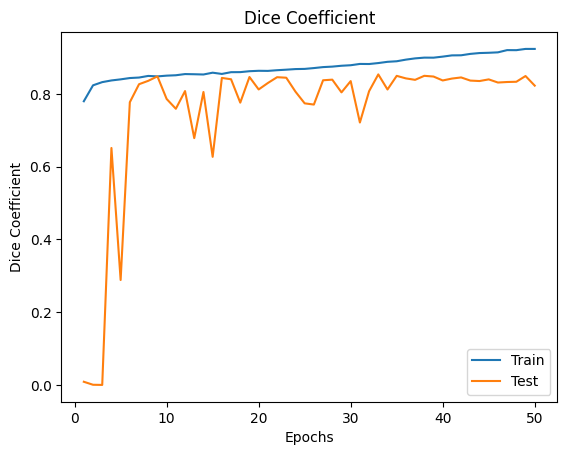

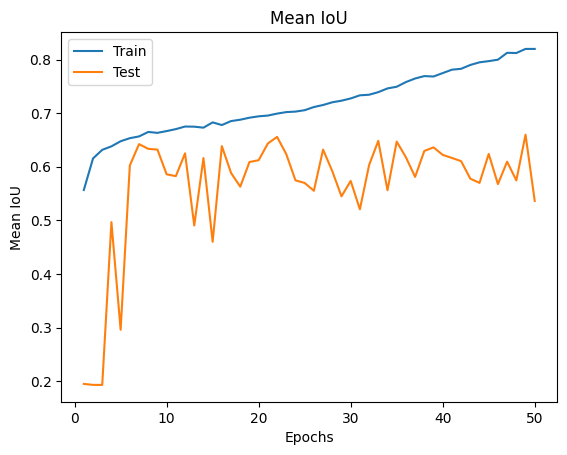

In [41]:
dice = results_unet_all.history['dice_coef']
val_dice = results_unet_all.history['val_dice_coef']
epochs = range(1, len(dice) + 1)
plt.plot(epochs, dice, label='Train')
plt.plot(epochs, val_dice, label='Test')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

iou = results_unet_all.history['mean_iou']
val_iou = results_unet_all.history['val_mean_iou']

plt.plot(epochs, iou, label='Train')
plt.plot(epochs, val_iou, label='Test')
plt.title('Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()